In [1]:
from model import ShallowNet
import torch
import torch.nn as nn
import torch.optim as optim
import preprocessing

import numpy as np

from sklearn.model_selection import KFold

import wandb

NVIDIA TITAN V


In [2]:
device = torch.device("cuda:3" if torch.cuda.is_available() else "cpu")
print(torch.cuda.get_device_name())

NVIDIA TITAN V


In [3]:
def train(config, train_loader, valid_loader):
    verbose = config["verbose"]
    # training
    loss_fn = nn.MSELoss(reduction="mean")
    loss_fn2 = nn.MSELoss(reduction="sum")

    epochs = config["epochs"]
    model = ShallowNet(2, config["hidden_layer"], 1)
    model.to(device)

    optimizer = torch.optim.SGD(model.parameters(), lr=config["lr"])
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=config["step_size"], gamma=config["gamma"])

    for epoch in range(epochs):
        lr = optimizer.param_groups[0]["lr"]
        running_loss = 0.
        last_loss = 0.

        for i, data in enumerate(train_loader):
            inputs, labels = data

            outputs = model(inputs)

            loss = loss_fn(outputs, labels)

            optimizer.zero_grad()

            loss.backward()

            optimizer.step()
            running_loss += loss.item()


            with torch.no_grad():
                if i % 1000 == 999:
                    last_loss = running_loss / (1000 * config["batch_size"]) # loss per batch
                    if verbose == 2:
                        print(f'batch {i+1} loss: {last_loss}')
                    wandb.log({"loss": last_loss})
                    running_loss = 0.
        
        scheduler.step()
        
        with torch.no_grad():
            # evaluate valid and train set
            running_valid_loss = 0.                
            for j, data in enumerate(valid_loader):
                inputs, labels = data
                outputs = model(inputs)
                loss = loss_fn2(outputs, labels)
                running_valid_loss += loss.item()

            running_train_loss = 0.
            for j, data in enumerate(train_loader):
                inputs, labels = data
                outputs = model(inputs)
                loss = loss_fn2(outputs, labels)
                running_train_loss += loss.item()
            
            train_err = np.sqrt(running_train_loss / len(train_loader.sampler.indices))
            if verbose == 1 or verbose == 2:
                print(f'epoch {epoch+1} train_err: {train_err}')
            
            val_err = np.sqrt(running_valid_loss/ len(valid_loader.sampler.indices))
            if verbose == 1 or verbose == 2:
                print(f'epoch {epoch+1} val_err: {val_err}')

            metrics = {"train_eval": train_err,
                        "val_eval": val_err,
                        "lr" : lr
                        }
                
            wandb.log(metrics)

    return model, train_err, val_err

In [4]:
run_config = {
    'model':'base 2-8-1',
    'hidden_layer': 8,
    'optimizer':'sgd',
    'lr': 1e-3,
    'batch_size': 2,
    # parameter for lr scehduler
    'step_size' : 2,
    'gamma' : 0.8,

    'epochs': 20,
    
    'verbose': 1, # verbose 0, 1, 2
}

In [5]:
# ==========================================
# --------- Q6 nested CV protocol ----------
# ==========================================
from preprocessing import CustomDataset
dataset = preprocessing.load_dataset(run_config)
kfold = KFold(3, shuffle=True, random_state=42)

train_datasets = []
test_datasets = []

for outter_fold, (train_idx, test_idx) in enumerate(kfold.split(dataset)):
    train_datasets.append(CustomDataset(dataset[train_idx][0], dataset[train_idx][1]))
    test_datasets.append(CustomDataset(dataset[test_idx][0], dataset[test_idx][1]))

### Inner Cross Validation for Outer Fold1

In [ ]:
# ======================= ########################################
# manually code this part ########################################
train_dataset = train_datasets[0]
# ======================= ########################################

for inner_fold, (train_idx, val_idx) in enumerate(kfold.split(train_dataset)):
    # ======================= ########################################
    # manually code this part ########################################
    model_name_base = "Out_Fold1: "
    # ======================= ########################################
    model_name_fold = model_name_base + "Fold" + str(inner_fold+1) + "_"

    train_subsampler = torch.utils.data.SubsetRandomSampler(train_idx)
    val_subsampler = torch.utils.data.SubsetRandomSampler(val_idx)

    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=run_config["batch_size"], sampler=train_subsampler)
    val_loader = torch.utils.data.DataLoader(train_dataset, batch_size=run_config["batch_size"], sampler=val_subsampler)

    for i, hidden_layer_num in enumerate([8, 24, 40, 56, 72]):
        model_name = model_name_fold + f"model:2-{hidden_layer_num}-1"
        run_config["model"] = model_name
        run_config["hidden_layer"] = hidden_layer_num
        run = wandb.init(
            project="NN-Assignment-CV", 
            job_type="Nested CV protocol", 
            name=run_config['model'], 
            config=run_config
            )
        model, train_err, val_err = train(run_config, train_loader, val_loader)
        print(f"{run_config['model']}: {train_err=}, {val_err=}")
        wandb.finish()

### Inner Cross Validation for Outer Fold2

In [ ]:
# ======================= ########################################
# manually code this part ########################################
train_dataset = train_datasets[1]
# ======================= ########################################

for inner_fold, (train_idx, val_idx) in enumerate(kfold.split(train_dataset)):
    # ======================= ########################################
    # manually code this part ########################################
    model_name_base = "Out_Fold2: "
    # ======================= ########################################
    model_name_fold = model_name_base + "Fold" + str(inner_fold+1) + "_"

    train_subsampler = torch.utils.data.SubsetRandomSampler(train_idx)
    val_subsampler = torch.utils.data.SubsetRandomSampler(val_idx)

    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=run_config["batch_size"], sampler=train_subsampler)
    val_loader = torch.utils.data.DataLoader(train_dataset, batch_size=run_config["batch_size"], sampler=val_subsampler)

    for i, hidden_layer_num in enumerate([8, 24, 40, 56, 72]):
        model_name = model_name_fold + f"model:2-{hidden_layer_num}-1"
        run_config["model"] = model_name
        run_config["hidden_layer"] = hidden_layer_num
        run = wandb.init(
            project="NN-Assignment-CV", 
            job_type="Nested CV protocol", 
            name=run_config['model'], 
            config=run_config
            )
        model, train_err, val_err = train(run_config, train_loader, val_loader)
        print(f"{run_config['model']}: {train_err=}, {val_err=}")
        wandb.finish()

### Inner Cross Validation for Outer Fold3

In [ ]:
# ======================= ########################################
# manually code this part ########################################
train_dataset = train_datasets[2]
# ======================= ########################################

for inner_fold, (train_idx, val_idx) in enumerate(kfold.split(train_dataset)):
    # ======================= ########################################
    # manually code this part ########################################
    model_name_base = "Out_Fold3: "
    # ======================= ########################################
    model_name_fold = model_name_base + "Fold" + str(inner_fold+1) + "_"

    train_subsampler = torch.utils.data.SubsetRandomSampler(train_idx)
    val_subsampler = torch.utils.data.SubsetRandomSampler(val_idx)

    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=run_config["batch_size"], sampler=train_subsampler)
    val_loader = torch.utils.data.DataLoader(train_dataset, batch_size=run_config["batch_size"], sampler=val_subsampler)

    for i, hidden_layer_num in enumerate([8, 24, 40, 56, 72]):
        model_name = model_name_fold + f"model:2-{hidden_layer_num}-1"
        run_config["model"] = model_name
        run_config["hidden_layer"] = hidden_layer_num
        run = wandb.init(
            project="NN-Assignment-CV", 
            job_type="Nested CV protocol", 
            name=run_config['model'], 
            config=run_config
            )
        model, train_err, val_err = train(run_config, train_loader, val_loader)
        print(f"{run_config['model']}: {train_err=}, {val_err=}")
        wandb.finish()

### Change train function for test loader

In [7]:
# train function for test error evaluation
def train(config, train_loader, test_loader):
    verbose = config["verbose"]
    # training
    loss_fn = nn.MSELoss(reduction="mean")
    loss_fn2 = nn.MSELoss(reduction="sum")

    epochs = config["epochs"]
    model = ShallowNet(2, config["hidden_layer"], 1)
    model.to(device)

    optimizer = torch.optim.SGD(model.parameters(), lr=config["lr"])
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=config["step_size"], gamma=config["gamma"])

    for epoch in range(epochs):
        lr = optimizer.param_groups[0]["lr"]
        running_loss = 0.
        last_loss = 0.

        for i, data in enumerate(train_loader):
            inputs, labels = data

            outputs = model(inputs)

            loss = loss_fn(outputs, labels)

            optimizer.zero_grad()

            loss.backward()

            optimizer.step()
            running_loss += loss.item()


            with torch.no_grad():
                if i % 1000 == 999:
                    last_loss = running_loss / (1000 * config["batch_size"]) # loss per batch
                    if verbose == 2:
                        print(f'batch {i+1} loss: {last_loss}')
                    wandb.log({"loss": last_loss})
                    running_loss = 0.
        
        scheduler.step()
        
        with torch.no_grad():
            # evaluate valid and train set
            running_valid_loss = 0.                
            for j, data in enumerate(test_loader):
                inputs, labels = data
                outputs = model(inputs)
                loss = loss_fn2(outputs, labels)
                running_valid_loss += loss.item()

            running_train_loss = 0.
            for j, data in enumerate(train_loader):
                inputs, labels = data
                outputs = model(inputs)
                loss = loss_fn2(outputs, labels)
                running_train_loss += loss.item()
            
            train_err = np.sqrt(running_train_loss / len(train_loader.dataset))
            if verbose == 1 or verbose == 2:
                print(f'epoch {epoch+1} train_err: {train_err}')
            
            test_err = np.sqrt(running_valid_loss/ len(test_loader.dataset))
            if verbose == 1 or verbose == 2:
                print(f'epoch {epoch+1} test_err: {test_err}')

            metrics = {"train_eval": train_err,
                        "test_eval": test_err,
                        "lr" : lr
                        }
                
            wandb.log(metrics)

    return model, train_err, test_err

### Train Outer Fold 1

In [12]:
# ##############################
train_dataset = train_datasets[0]
test_dataset = test_datasets[0]
model_name_base = "Out_Fold1: "
hidden_layer_num = 8
# ##############################
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=run_config["batch_size"], shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=run_config["batch_size"], shuffle=True)

model_name_fold = model_name_base + "Test" + "_"

model_name = model_name_fold + f"model:2-{hidden_layer_num}-1"
run_config["model"] = model_name
run_config["hidden_layer"] = hidden_layer_num
run = wandb.init(
    project="NN-Assignment-CV",
    job_type="Error Test",
    name=run_config['model'],
    config=run_config
    )
model, train_err, val_err = train(run_config, train_loader, test_loader)

loss,█▂█▆▆▆▅▃▅▃▅▂▄▄▄▃▅▄▄▅▄▄▄▆▄▄▃▁▄▃▃▆▄▄▂▆▅▃▃▄
lr,██▆▆▅▅▄▄▃▃▃▃▂▂▂▂▁▁▁▁
test_eval,▄▄▅▂█▂▂▂▂▂▁▂▂▂▁▂▁▁▁▁
train_eval,▄▄▄▂█▂▂▂▁▂▁▂▂▂▁▂▁▁▁▁
loss,0.15064
lr,0.00013
test_eval,0.77188
train_eval,0.77447


epoch 1 train_err: 0.7896063735690294
epoch 1 test_err: 0.7899894547094349
epoch 2 train_err: 0.7849155372661514
epoch 2 test_err: 0.7828394226217986
epoch 3 train_err: 0.7821417207215662
epoch 3 test_err: 0.7805368181375196
epoch 4 train_err: 0.7810091870919729
epoch 4 test_err: 0.7803986683604665
epoch 5 train_err: 0.779633499892667
epoch 5 test_err: 0.7780341999462335
epoch 6 train_err: 0.7810507330298192
epoch 6 test_err: 0.7790044471150841
epoch 7 train_err: 0.7782847789992028
epoch 7 test_err: 0.7770794025092699
epoch 8 train_err: 0.7819761029494445
epoch 8 test_err: 0.7804915294071891
epoch 9 train_err: 0.7784403250053381
epoch 9 test_err: 0.7772320680097741
epoch 10 train_err: 0.7780694643483543
epoch 10 test_err: 0.7768316581788018
epoch 11 train_err: 0.7810642599906797
epoch 11 test_err: 0.7809708910954334
epoch 12 train_err: 0.7771909488898064
epoch 12 test_err: 0.7767008802613282
epoch 13 train_err: 0.7770512365960445
epoch 13 test_err: 0.7764758309271605
epoch 14 train_err

### Visualization with trained model1

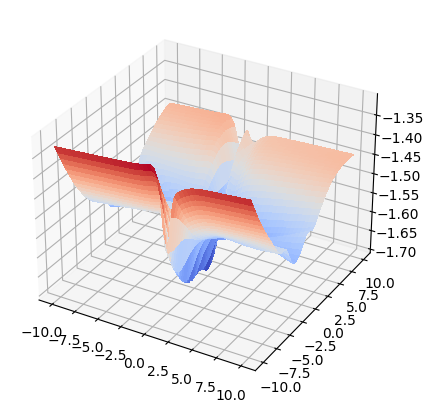

In [13]:
x = np.linspace(-10, 10, num=200)
y = np.linspace(-10, 10, num=200)

xx, yy = np.meshgrid(x, y)

xx = xx.reshape(-1, 1)
yy = yy.reshape(-1, 1)

input = np.concatenate([xx, yy], axis=1)
input = torch.Tensor(input)
input = input.to(device)

zz = model(input).detach().cpu().numpy()

import matplotlib.pyplot as plt
from matplotlib import cm

xx = xx.reshape(200, 200)
yy = yy.reshape(200, 200)
zz = zz.reshape(200, 200)
fig, ax = plt.subplots(subplot_kw={"projection":"3d"}, figsize = (5,5))
surf = ax.plot_surface(xx, yy, zz, cmap=cm.coolwarm, linewidth=0, antialiased=False)
plt.show()

### Train Outer Fold 2

In [ ]:
# ##############################
train_dataset = train_datasets[1]
test_dataset = test_datasets[1]
model_name_base = "Out_Fold2: "
hidden_layer_num = 56
# ##############################
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=run_config["batch_size"], shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=run_config["batch_size"], shuffle=True)

model_name_fold = model_name_base + "Test" + "_"

model_name = model_name_fold + f"model:2-{hidden_layer_num}-1"
run_config["model"] = model_name
run_config["hidden_layer"] = hidden_layer_num
run = wandb.init(
    project="NN-Assignment-CV",
    job_type="Error Test",
    name=run_config['model'],
    config=run_config
    )
model, train_err, val_err = train(run_config, train_loader, test_loader)

### Visualization with trained model2

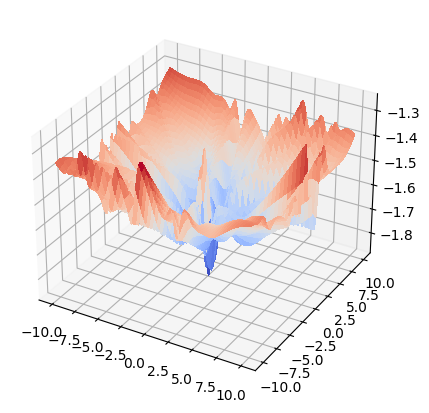

In [11]:
x = np.linspace(-10, 10, num=200)
y = np.linspace(-10, 10, num=200)

xx, yy = np.meshgrid(x, y)

xx = xx.reshape(-1, 1)
yy = yy.reshape(-1, 1)

input = np.concatenate([xx, yy], axis=1)
input = torch.Tensor(input)
input = input.to(device)

zz = model(input).detach().cpu().numpy()

import matplotlib.pyplot as plt
from matplotlib import cm

xx = xx.reshape(200, 200)
yy = yy.reshape(200, 200)
zz = zz.reshape(200, 200)
fig, ax = plt.subplots(subplot_kw={"projection":"3d"}, figsize = (5,5))
surf = ax.plot_surface(xx, yy, zz, cmap=cm.coolwarm, linewidth=0, antialiased=False)
plt.show()

### Train Outer Fold 3

In [14]:
# ##############################
train_dataset = train_datasets[2]
test_dataset = test_datasets[2]
model_name_base = "Out_Fold3: "
hidden_layer_num = 40
# ##############################
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=run_config["batch_size"], shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=run_config["batch_size"], shuffle=True)

model_name_fold = model_name_base + "Test" + "_"

model_name = model_name_fold + f"model:2-{hidden_layer_num}-1"
run_config["model"] = model_name
run_config["hidden_layer"] = hidden_layer_num
run = wandb.init(
    project="NN-Assignment-CV",
    job_type="Error Test",
    name=run_config['model'],
    config=run_config
    )
model, train_err, val_err = train(run_config, train_loader, test_loader)

loss,▆▄▅▅█▄█▃▅▅▆▁▄▂▂█▁▃▅▄▂▅▃▅▇▄▅▄▁▄▅▁▃▆▁▆▃▆▄▃
lr,██▆▆▅▅▄▄▃▃▃▃▂▂▂▂▁▁▁▁
test_eval,█▄▃▃▂▂▂▃▂▁▃▁▁▁▁▁▁▂▂▁
train_eval,█▅▄▃▃▃▂▄▂▂▃▁▁▁▁▁▁▁▂▁
loss,0.15077
lr,0.00013
test_eval,0.77605
train_eval,0.77717


epoch 1 train_err: 0.7896812203543198
epoch 1 test_err: 0.7942853956521577
epoch 2 train_err: 0.7870577005863872
epoch 2 test_err: 0.7887018690727732
epoch 3 train_err: 0.8404835376911856
epoch 3 test_err: 0.8404265102363396
epoch 4 train_err: 0.9241876669322681
epoch 4 test_err: 0.9230343783148853
epoch 5 train_err: 0.7855279162129224
epoch 5 test_err: 0.7905972085373414
epoch 6 train_err: 0.7845153807204428
epoch 6 test_err: 0.7891862631102681
epoch 7 train_err: 0.7791994174826399
epoch 7 test_err: 0.7827439090577848
epoch 8 train_err: 0.7804057921597013
epoch 8 test_err: 0.7834731535934647
epoch 9 train_err: 0.7827864184305914
epoch 9 test_err: 0.7872133287645179
epoch 10 train_err: 0.786587348019721
epoch 10 test_err: 0.7869642020288276
epoch 11 train_err: 0.776975432329345
epoch 11 test_err: 0.7802846034084624
epoch 12 train_err: 0.7789919759943236
epoch 12 test_err: 0.7852958224051547
epoch 13 train_err: 0.7748496473993551
epoch 13 test_err: 0.7788149982082153
epoch 14 train_err:

### Visualization with trained model3

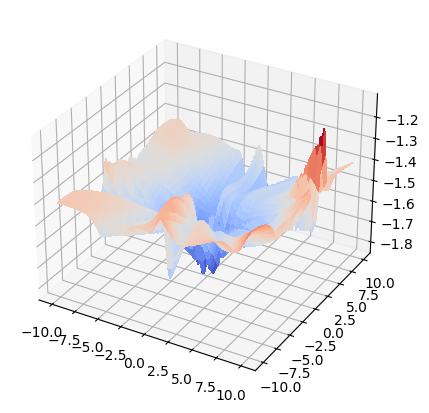

: 

In [15]:
x = np.linspace(-10, 10, num=200)
y = np.linspace(-10, 10, num=200)

xx, yy = np.meshgrid(x, y)

xx = xx.reshape(-1, 1)
yy = yy.reshape(-1, 1)

input = np.concatenate([xx, yy], axis=1)
input = torch.Tensor(input)
input = input.to(device)

zz = model(input).detach().cpu().numpy()

import matplotlib.pyplot as plt
from matplotlib import cm

xx = xx.reshape(200, 200)
yy = yy.reshape(200, 200)
zz = zz.reshape(200, 200)
fig, ax = plt.subplots(subplot_kw={"projection":"3d"}, figsize = (5,5))
surf = ax.plot_surface(xx, yy, zz, cmap=cm.coolwarm, linewidth=0, antialiased=False)
plt.show()

In [75]:
(xx.reshape(200,200) == np.meshgrid(x,y)[0]).all()

True

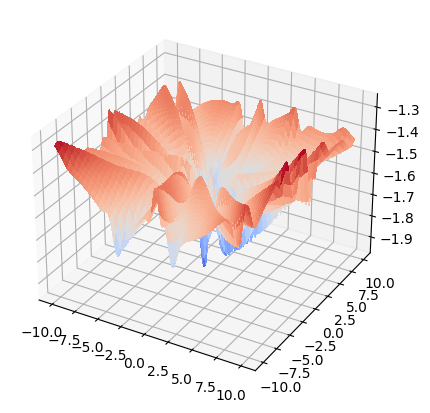

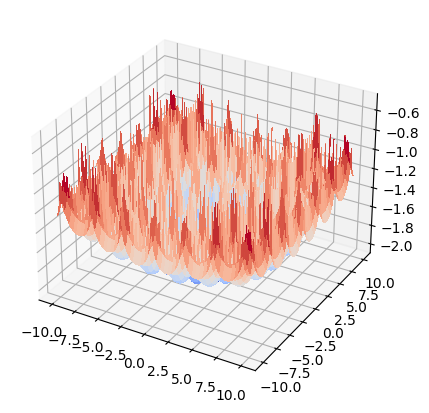

In [77]:
# ======================================
# ---------- Q1 Generate Data ----------
# ======================================
x = np.linspace(-10, 10, num=200)
y = np.linspace(-10, 10, num=200)

xx, yy = np.meshgrid(x, y)
zz = -0.0001*(np.abs(np.sin(xx)*np.sin(yy)*np.exp(np.abs(100 - np.sqrt(xx**2 +yy**2)/np.pi))) + 1)**0.1

# --- data visualization starts

fig, ax = plt.subplots(subplot_kw={"projection":"3d"}, figsize = (5,5))
surf = ax.plot_surface(xx, yy, zz, cmap=cm.coolwarm, linewidth=0, antialiased=False)
plt.show()

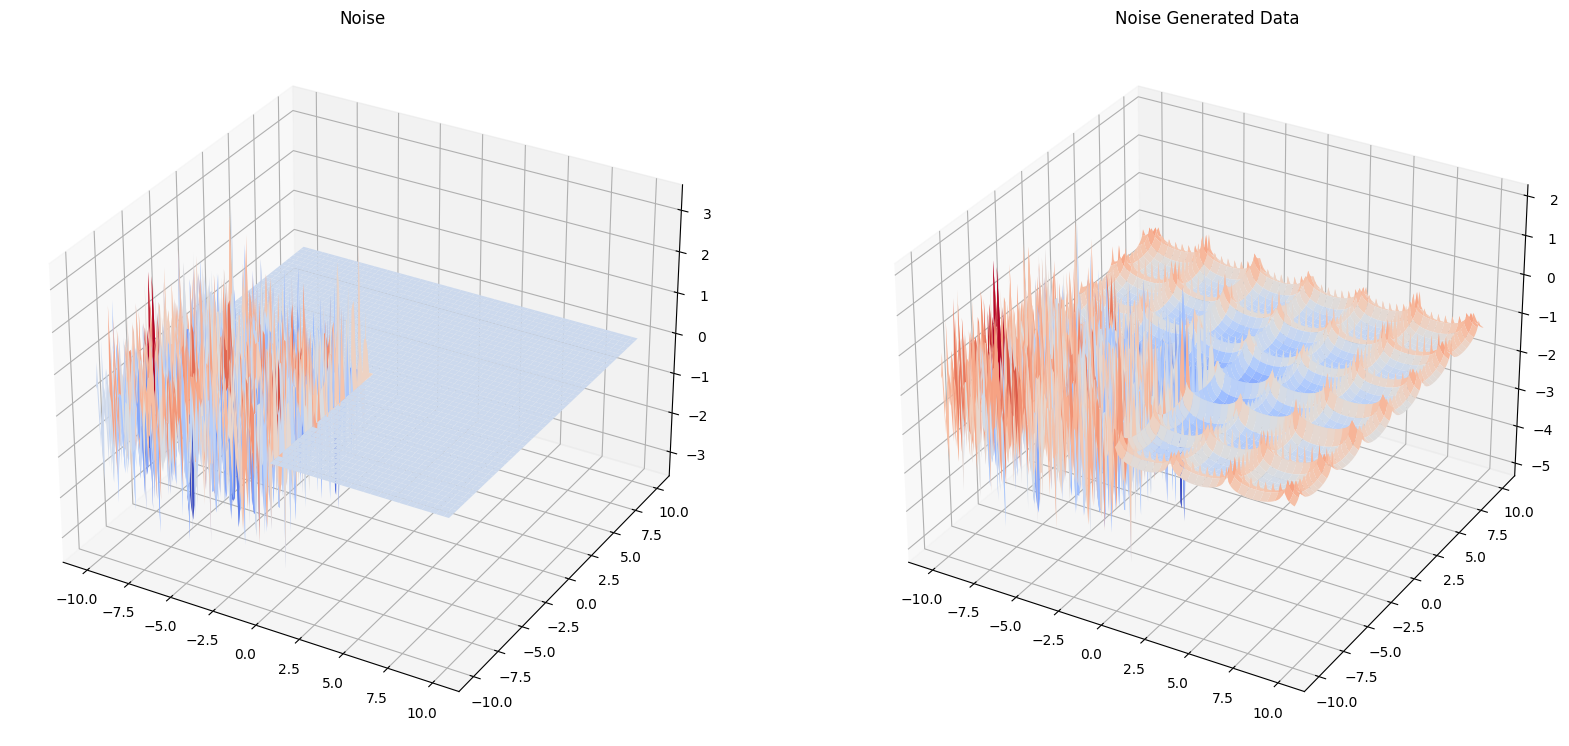

In [78]:
# ==========================================
# ---------- Q2 Add Noise to data ----------
# ==========================================
mask = (-10 <= xx) * (xx <= 0) * (-10 <= yy) * (yy <= 0)
noise = mask * np.random.randn(200, 200)

zz += noise

# --- data visualization starts

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, subplot_kw={"projection": "3d"}, figsize = (20,20))
surf = ax1.plot_surface(xx, yy, noise, cmap=cm.coolwarm)
ax1.set_title("Noise")
surf = ax2.plot_surface(xx, yy, zz, cmap=cm.coolwarm)
ax2.set_title("Noise Generated Data")
plt.show()

# --- data visualization ends

In [38]:
yy.shape

(40000, 1)

In [39]:
train_dataset[0]

(tensor([-10., -10.], device='cuda:3'), tensor(-1.5793, device='cuda:3'))

In [40]:
type(xx)

numpy.ndarray

In [41]:
np.concatenate([xx, yy], axis=1).shape

(40000, 2)